In [1]:
#Bibliotecas
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
import pandas as pd
from skimage.feature import hog
#Machine Learning 
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
#Dl
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import tensorflow as tf
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

%matplotlib inline

Using TensorFlow backend.


In [21]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l,cn):
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.5f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Fold'+str(cn))
    plt.legend(loc="lower right")
    return(plt)

## DeepLearner Feature Extraction

In [3]:
modelo = models.load_model('estomato_vgg16.h5')

In [4]:
#modelo.pop()
modelo.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


In [5]:
dir_estomato = "/home/nagai/Documents/Projects/Estomatos_PI/Imagens/dataset/STOMA/"
dir_erro = "/home/nagai/Documents/Projects/Estomatos_PI/Imagens/dataset/ERRO/"

list_stoma = sorted(os.listdir(dir_estomato))
list_erro = sorted(os.listdir(dir_erro))
img_estomatos = []
img_erros = []


In [6]:
for i in list_stoma:
    img_estomatos.append(cv2.imread(dir_estomato+i))
for i in list_erro:
    img_erros.append(cv2.imread(dir_erro+i))


In [7]:
teste = np.array(cv2.resize(img_estomatos[0],(224,224)))


In [8]:
teste = teste.reshape(1,224,224,3)

In [9]:
modelo.summary()
modelo.pop()
modelo.pop()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


In [10]:
modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [11]:
data = list()
for i in img_estomatos:
    resized_image = cv2.resize(i, (224, 224)) 
    ynew = modelo.predict(resized_image.reshape(1,224,224,3))
    tmp = np.append(ynew,1)
    data.append(tmp)
    
for i in img_erros:
    resized_image = cv2.resize(i, (224, 224)) 
    ynew = modelo.predict(resized_image.reshape(1,224,224,3))
    tmp = np.append(ynew,0)
    data.append(tmp)
 

In [12]:
data = pd.DataFrame(data)

In [13]:
list_stoma = [i[:-5] for i in list_stoma]
list_erro = [i[:-5] for i in list_erro]

In [14]:
data

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.000000,0.000000,22.674183,68.808441,3.789677,42.102936,7.413155,35.391518,0.000000,0.000000,...,0.000000,14.182872,0.000000,25.129168,0.000000,0.000000,0.000000,53.492908,0.000000,1.0
1,32.384384,0.000000,41.724510,154.728226,4.955225,104.136887,0.000000,59.121326,0.000000,0.000000,...,0.000000,13.135114,0.000000,34.558056,0.000000,0.000000,0.000000,122.168007,0.000000,1.0
2,0.000000,0.000000,55.734344,147.580704,11.325633,79.731560,0.000000,110.051529,0.000000,0.000000,...,0.000000,0.000000,0.000000,34.669003,0.000000,0.000000,0.000000,112.489807,0.000000,1.0
3,0.000000,30.541065,69.602737,40.580360,8.814088,21.473528,12.994819,74.089462,0.000000,0.000000,...,0.000000,0.000000,0.000000,38.086880,0.000000,0.000000,0.000000,83.401024,0.000000,1.0
4,22.104774,1.707705,55.164951,207.206604,1.742649,155.149750,0.000000,65.250145,0.000000,0.000000,...,0.000000,31.510422,0.000000,18.217163,0.000000,0.000000,0.000000,150.875702,0.000000,1.0
5,73.562881,0.000000,49.728970,100.826736,5.684058,147.121841,0.000000,118.457283,0.000000,17.591673,...,0.000000,29.068434,0.000000,73.014534,0.000000,0.000000,0.000000,222.450546,0.000000,1.0
6,58.713886,28.292362,49.275372,132.465851,0.000000,264.410492,0.000000,33.006638,2.712622,0.000000,...,0.000000,9.778758,0.000000,66.670807,0.000000,5.610307,0.000000,102.189529,0.000000,1.0
7,0.000000,0.000000,2.316991,144.030899,4.260983,138.188385,0.000000,118.996559,0.000000,27.153666,...,43.559582,56.766327,0.000000,68.628860,0.000000,35.796196,8.305499,141.010757,0.000000,1.0
8,0.000000,26.188572,56.444008,94.750809,5.544255,0.000000,13.636851,60.293537,0.000000,1.050968,...,0.000000,0.812285,7.395647,5.534287,0.000000,0.000000,0.000000,111.296364,0.000000,1.0
9,71.306854,0.000000,0.000000,163.577377,0.000000,188.774368,0.000000,130.870605,0.000000,0.000000,...,53.707561,22.885918,0.000000,67.335899,0.000000,38.211319,0.000000,173.913116,0.000000,1.0


In [15]:
data['class'] = data[1024]
#data['nome'] = list_stoma+list_erro
data = data.drop(columns=[1024])
data.to_csv('features_vgg16.csv')

In [16]:
from sklearn.model_selection import StratifiedKFold
X = data.iloc[:,:-1]
y = data['class']
skf = StratifiedKFold(n_splits=5)
classifiers = [
    SVC(kernel="linear", C=0.025, probability=True),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
]
    
cls = ["SVM linear",
       "MLP",
       "AdaBoost",
]

In [17]:
fold = [[],[],[],[],[]]
k = 0
for i in range(0,2000,5):
    for j in range(5):
        fold[k%5].append(j+i)
    k+=1
tt1 = fold[0]+fold[1]+fold[2]+fold[3],fold[4]
tt2 = fold[1]+fold[2]+fold[3]+fold[4],fold[0]
tt3 = fold[0]+fold[2]+fold[3]+fold[4],fold[1]
tt4 = fold[0]+fold[1]+fold[3]+fold[4],fold[2]
tt5 = fold[0]+fold[1]+fold[2]+fold[4],fold[3]

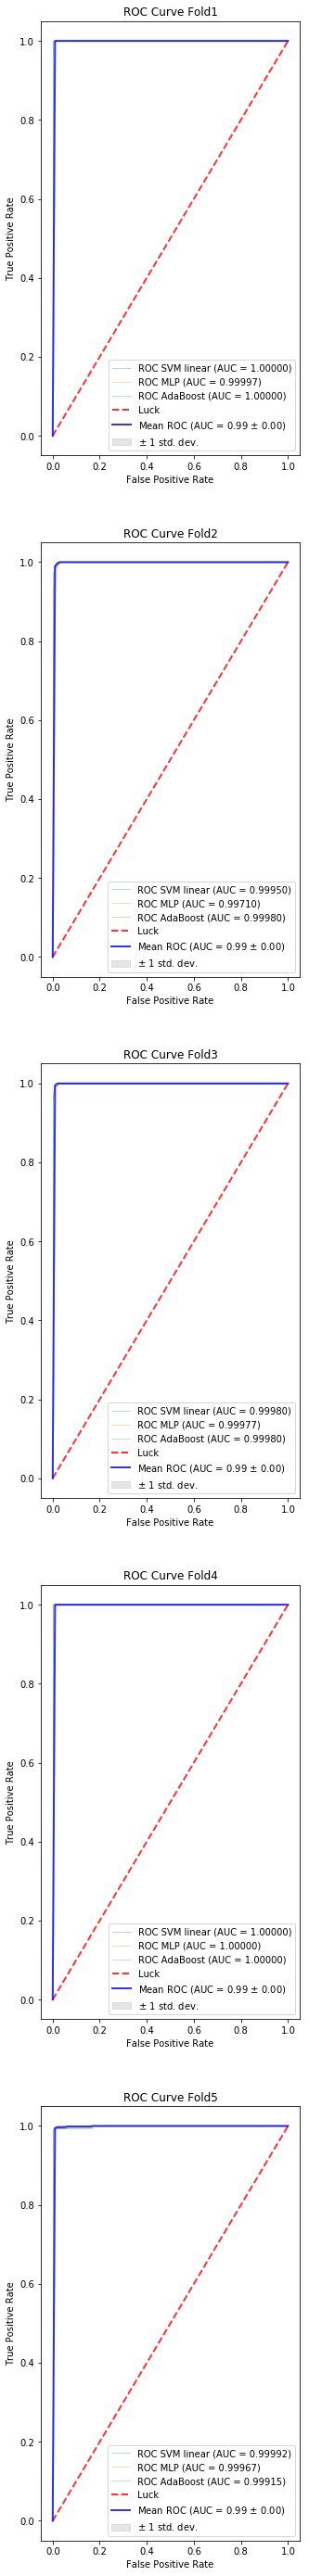

In [31]:
skf = StratifiedKFold(n_splits=5)
fig = plt.figure(figsize=(5,50))
row = 5
col = 1
i = 1
cnt2 = 1
aux_data = data.iloc[:,:-1]
for train, test in [tt1,tt2,tt3,tt4,tt5]:
    tprs_dall = []
    aucs_dall = []
    mean_fpr_dall = np.linspace(0, 1, 100)
    a = fig.add_subplot(row, col, i)
    imgshow = roc(aux_data.iloc[train],data['class'][train],aux_data.iloc[test],data['class'][test], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls, cnt2)
    i+=1
    cnt2+=1

plt.savefig('RoC.jpeg')

In [19]:
img = cv2.imread('/home/nagai/Documents/Projects/Estomatos_PI/Imagens/data_final/teste.jpg')